# Purpose

This notebook shows how to learn the distribution of a data and then simulate samples from that learned distribution. 

# Motivating example

Let's say we observe a random variable $X$. When we plot the distribution of $X$, we observe something like the following. Here, we know that the observations of $X$ actually came from a mixure of gaussians (but pretend we did not know).

* $X_0 \sim \mathcal{N}(0, 1)$
* $X_1 \sim \mathcal{N}(5, 1)$
* $X_2 \sim \mathcal{N}(10, 2)$

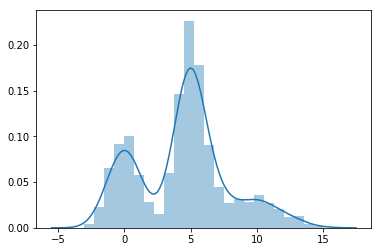

In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(37)

x0 = np.random.normal(0, 1, 500)
x1 = np.random.normal(5, 1, 1000)
x2 = np.random.normal(10, 2, 300)
X = np.concatenate([x0, x1, x2]).reshape(-1, 1)

sns.distplot(X)

# k-means clustering (KMC)

We apply k-means clustering to $X$ to see where the clusters are for k=2, 3, 4, 5 and 6. For each k, we evaluate the clustering results using the silhouette score, choosing the k with the largest silhouette score. In this case, k=3 has the highest silhouette score.

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def get_silhouette_score(X, k):
    print('starting k={}'.format(k))
    model = KMeans(k, random_state=37, n_jobs=-1)
    model.fit(X)
    labels = model.predict(X)
    score = silhouette_score(X, labels)
    return score

kms_scores = sorted([(k, get_silhouette_score(X, k)) for k in range(2, 6)], key=lambda tup: (-tup[1], tup[0]))

starting k=2
starting k=3
starting k=4
starting k=5


In [3]:
kms_scores

[(3, 0.7068431322753701),
 (2, 0.6343853947741563),
 (4, 0.6067295633567155),
 (5, 0.5721530284698704)]

# Gaussian Mixture Model (GMM)

KMC gave us evidence to believe that $X$ has 3 modes (sub-populations). Let's use k=3 to learn a gaussian mixture model (GMM).

In [4]:
from sklearn.mixture import GaussianMixture

def get_gmm_labels(X, k):
    gmm = GaussianMixture(n_components=k, max_iter=50, covariance_type='spherical', random_state=37)
    gmm.fit(X)
    labels = gmm.predict(X)
    labels = np.array([0 if label == 1 else 1 for label in labels])
    return labels, gmm

labels, gmm = get_gmm_labels(X, kms_scores[0][0])

Since we used k=3 from KMC to define the number of components for GMM, we should expect the number of components to be 3.

In [5]:
gmm.n_components

3

Here are the means, covariances and weights learned from GMM.

In [6]:
print(gmm.means_.reshape(1, -1)[0])
print(np.sqrt(gmm.covariances_))
print(gmm.weights_)

[0.01368472 5.0550979  9.96071725]
[1.01027696 1.03395708 1.86489054]
[0.27806376 0.56339635 0.15853989]


In [7]:
gaussians = {}
for label, mu, std in zip(range(gmm.n_components), gmm.means_.reshape(1, -1)[0], np.sqrt(gmm.covariances_)):
    print('{} : {}, {}'.format(label, mu, std))
    gaussians[label] = (mu, std)

0 : 0.013684724179380126, 1.0102769579001167
1 : 5.055097898869678, 1.0339570763110615
2 : 9.960717253224306, 1.8648905391181014


# Simulation using Dirichlet

Now we can simulate samples using the gaussians mixture distribution weights as inputs for the [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution). Note that the code below gives the label with the highest probability per sampling run. After we sample a label from the Dirichlet, we then sample from the gaussian corresponding to the label to form, $S$, the simulated data.

Note that we can simulate the data directly from the GMM `gmm.sample(10)`, but where's the fun in that?

In [8]:
from scipy.stats import dirichlet

mu_indices = np.argmax(dirichlet.rvs(gmm.weights_, size=X.shape[0], random_state=37), axis=1)

In [9]:
S = np.array([np.random.normal(gaussians[idx][0], gaussians[idx][1]) for idx in mu_indices]).reshape(-1, 1)

Plotting the distribution of $S$ reveals something that looks like the distribution of $X$.

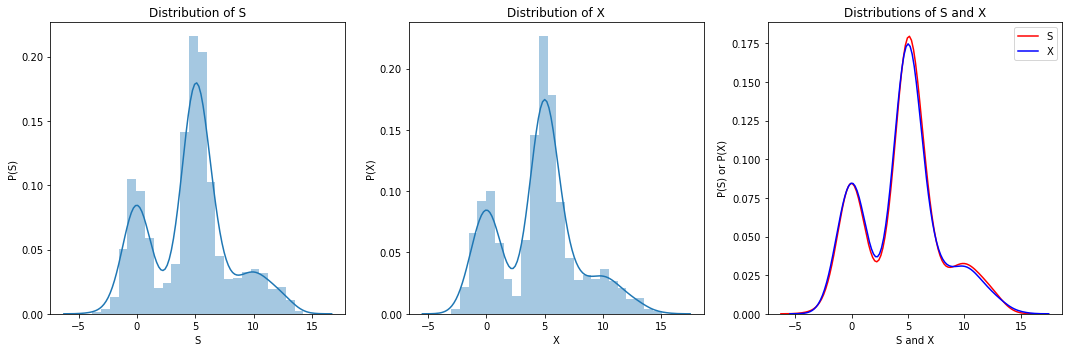

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax = np.ravel(ax)

sns.distplot(S, ax=ax[0])
sns.distplot(X, ax=ax[1])
sns.distplot(S, ax=ax[2], hist=False, color='red', label='S')
sns.distplot(X, ax=ax[2], hist=False, color='blue', label='X')

ax[0].set_xlabel('S')
ax[0].set_ylabel('P(S)')
ax[0].set_title('Distribution of S')
ax[1].set_xlabel('X')
ax[1].set_ylabel('P(X)')
ax[1].set_title('Distribution of X')
ax[2].set_xlabel('S and X')
ax[2].set_ylabel('P(S) or P(X)')
ax[2].set_title('Distributions of S and X')
ax[2].legend()

plt.tight_layout()

# Testing the closeness of the simulated and empirical data

We can quantify the closeness of the simulated and empirical data using Pearson correlation (we have to sort the data first).

In [11]:
from scipy.stats import pearsonr

pearsonr(np.sort(S.reshape(1, -1)[0]), np.sort(X.reshape(1, -1)[0]))

(0.999315705823065, 0.0)

We can also do a [Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) to see how well the two data sets align.

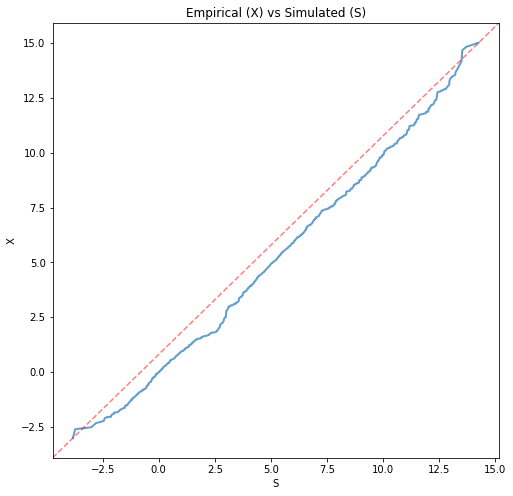

In [12]:
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(np.sort(S.reshape(1, -1)[0]), np.sort(X.reshape(1, -1)[0]), lw=2, alpha=0.7)
ax.set_title('Empirical (X) vs Simulated (S)')
ax.set_ylabel('X')
ax.set_xlabel('S')
ax.yaxis.set_major_locator(MaxNLocator(8))
ax.xaxis.set_major_locator(MaxNLocator(8))
xmin, xmax = ax.get_xbound()
ymin, ymax = ax.get_ybound()
line = mlines.Line2D([xmin, xmax], [ymin, ymax], c='red', ls='--', alpha=0.5)
ax.add_line(line)

# Computing the probability of a data point given the GMM

You may also estimate the probability of a data point given the GMM as follows,

$P(x | G) = p'w$,

where

* $x$ is the data point,
* $G$ is the GMM model,
* $p$ is a vector of probabilities as estimated by the gaussians in the GMM, and
* $w$ is a vector of the weights of the gaussians in the GMM.

Below, we estimate the probability of 1,000 $x \in X$ equally spaced, $X \in [-5, 15]$.

In [13]:
from scipy import stats

x_min = -5
x_max = 15
total = 1000
probs = []
for v in np.linspace(x_min, x_max, num=total):
    p = np.array([stats.norm.pdf(v, gaussians[label][0], gaussians[label][1]) for label in range(3)])
    p = p.dot(gmm.weights_)
    probs.append(p)
probs = np.array(probs)

We then plot the probabilities over $X$, and this curve looks just like the simulated and empirical data's distribution plots.

Text(0.5,0,'X')

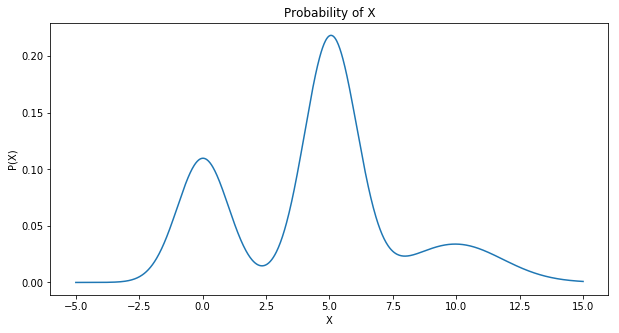

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.linspace(x_min, x_max, num=total), probs)
ax.set_title('Probability of X')
ax.set_ylabel('P(X)')
ax.set_xlabel('X')

Lastly, we can verify that the curve represents a probability distribution through integration.

In [15]:
from scipy.integrate import simps
from numpy import trapz

dx = (x_max - x_min) / total

print('trapezoid integration area {:.5f}'.format(trapz(probs, dx=dx)))
print('simpsons integration area {:.5f}'.format(simps(probs, dx=dx)))

trapezoid integration area 0.99845
simpsons integration area 0.99845
